**Warning:**
Sebelum melakukan klasifikasi, dilakukan import data, data yang digunakan diambil dari dataset breast cancer pada library sklearn

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(np.c_[cancer['data'], cancer['target']],
                  columns= np.append(cancer['feature_names'], ['target']))

In [2]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [3]:
df[['target']].value_counts()

target
1.0       357
0.0       212
dtype: int64

**Preprocessing Singkat**

*1. Feature Selection*

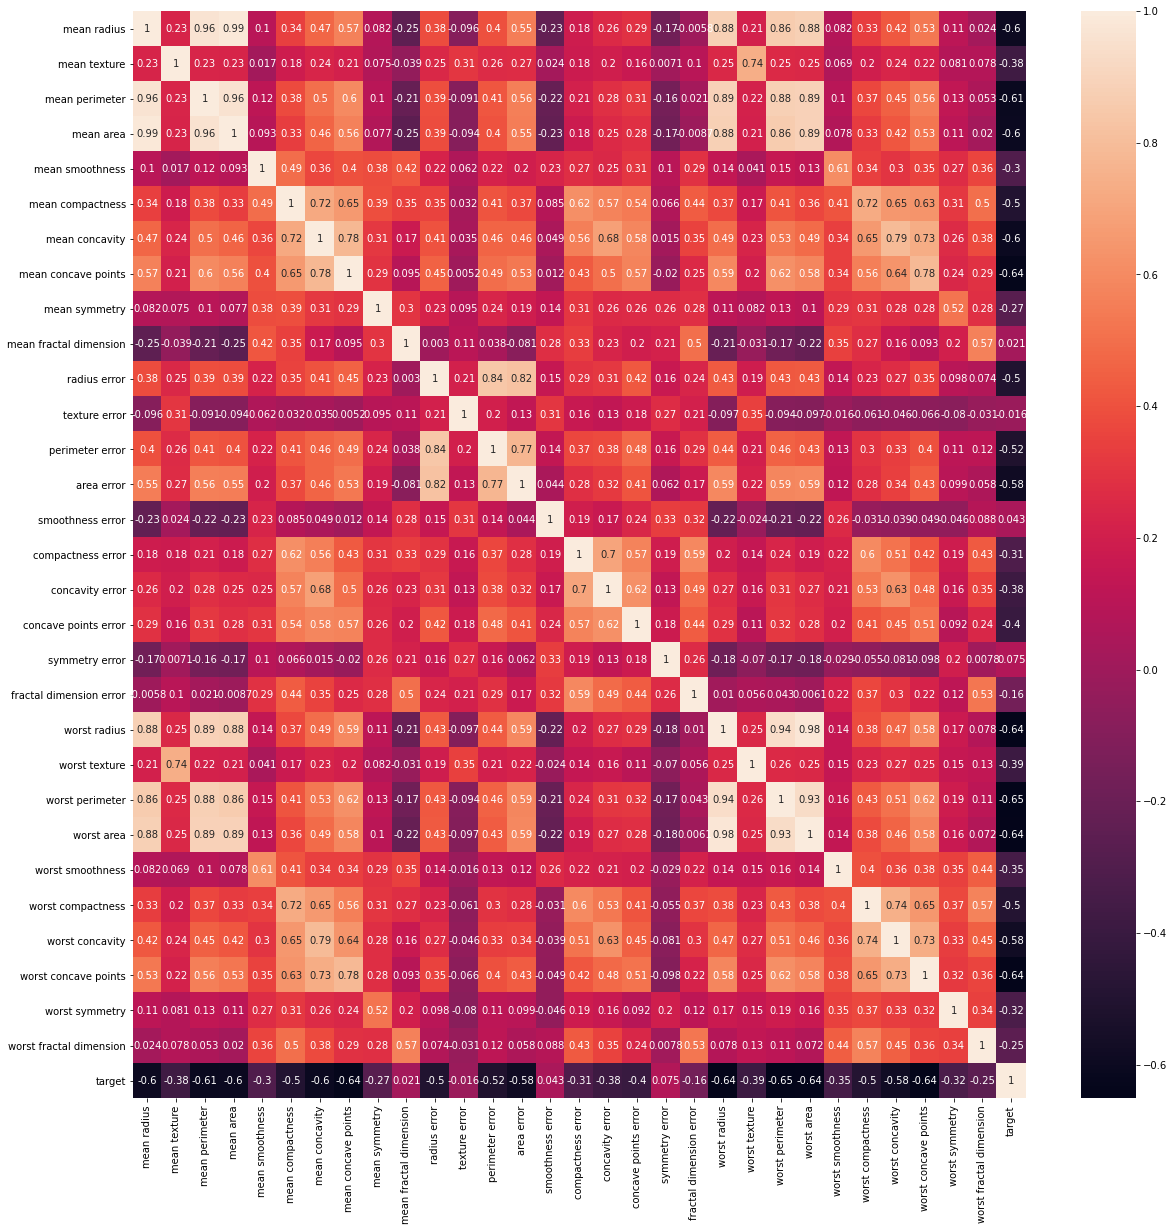

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,20))
cor = df.corr(method='kendall')
sns.heatmap(cor,annot=True)
plt.show()

In [7]:
fs=['mean radius','mean perimeter','mean area','mean concavity','mean concave points','perimeter error','area error',
    'worst radius','worst perimeter','worst area','worst concavity','worst concave points','target']
df_baru=df[fs]
df_baru.head()

,mean radius,mean perimeter,mean area,mean concavity,mean concave points,perimeter error,area error,worst radius,worst perimeter,worst area,worst concavity,worst concave points,target
0,17.99,122.80,1001.0,0.3001,0.14710,8.589,153.40,25.38,184.60,2019.0,0.7119,0.2654,0.0
1,20.57,132.90,1326.0,0.0869,0.07017,3.398,74.08,24.99,158.80,1956.0,0.2416,0.1860,0.0
2,19.69,130.00,1203.0,0.1974,0.12790,4.585,94.03,23.57,152.50,1709.0,0.4504,0.2430,0.0
3,11.42,77.58,386.1,0.2414,0.10520,3.445,27.23,14.91,98.87,567.7,0.6869,0.2575,0.0
4,20.29,135.10,1297.0,0.1980,0.10430,5.438,94.44,22.54,152.20,1575.0,0.4000,0.1625,0.0


*2. Scaling*

Scaling (0,1) dilakukan karena untuk mendapatkan hasil analisis yang lebih akurat karena pada jaringan syaraf tiruan, fungsi aktivasi yang digunakan kebanyakan berada di rentang 0 sampai 1.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_baru[fs] = scaler.fit_transform(df_baru[fs])
df_baru.columns = ['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','Y']
df_baru.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,0.521037,0.545989,0.363733,0.703140,0.731113,0.369034,0.273811,0.620776,0.668310,0.450698,0.568610,0.912027,0.0
1,0.643144,0.615783,0.501591,0.203608,0.348757,0.124440,0.125660,0.606901,0.539818,0.435214,0.192971,0.639175,0.0
2,0.601496,0.595743,0.449417,0.462512,0.635686,0.180370,0.162922,0.556386,0.508442,0.374508,0.359744,0.835052,0.0
3,0.210090,0.233501,0.102906,0.565604,0.522863,0.126655,0.038155,0.248310,0.241347,0.094008,0.548642,0.884880,0.0
4,0.629893,0.630986,0.489290,0.463918,0.518390,0.220563,0.163688,0.519744,0.506948,0.341575,0.319489,0.558419,0.0


# Multilayer Perceptron Menggunakan Keras


Membagi data menjadi data train dan data test

In [9]:
from sklearn.model_selection import train_test_split
X=df_baru[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12']]
y=df_baru[['Y']]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2,random_state=0)

install dan import library yang dibutuhkan dan membangun model awal

In [10]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import  Adam

def create_model(learn_rate=0.01, neurons=1):
	# membuat model dengan beberapa layer
  model = Sequential()
  model.add(Dense(neurons, input_dim=12))
  model.add(Dense(1, activation='relu'))
	# Compile model dengan optimasi adam
  optimizer=Adam()
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [23]:
# fix random seed for reproducibility
seed = 12
numpy.random.seed(seed)
#model
model = KerasClassifier(build_fn=create_model,epochs=100, batch_size=10, verbose=0)
# menentukan parameter model yang akan ditunning
learn_rate = [0.001, 0.01, 0.1]
neurons = [12, 15, 19]
param = dict(learn_rate=learn_rate, neurons=neurons)
gridmodel = GridSearchCV(estimator=model, param_grid=param, n_jobs=-1, cv=3)
gridmodel_result = gridmodel.fit(xTrain, yTrain)
# melihat hasil pencarian parameter terbaik 
print("Terbaik: %f Parameter %s" % (gridmodel_result.best_score_, gridmodel_result.best_params_))
means = gridmodel_result.cv_results_['mean_test_score']
stds = gridmodel_result.cv_results_['std_test_score']
params = gridmodel_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) dengan: %r" % (mean, stdev, param))

Terbaik: 0.947281 Parameter {'learn_rate': 0.01, 'neurons': 12}
0.942910 (0.018772) dengan: {'learn_rate': 0.001, 'neurons': 12}
0.947267 (0.014166) dengan: {'learn_rate': 0.001, 'neurons': 15}
0.942910 (0.017166) dengan: {'learn_rate': 0.001, 'neurons': 19}
0.947281 (0.009181) dengan: {'learn_rate': 0.01, 'neurons': 12}
0.938451 (0.011241) dengan: {'learn_rate': 0.01, 'neurons': 15}
0.755228 (0.262423) dengan: {'learn_rate': 0.01, 'neurons': 19}
0.920762 (0.038008) dengan: {'learn_rate': 0.1, 'neurons': 12}
0.927515 (0.014051) dengan: {'learn_rate': 0.1, 'neurons': 15}
0.938480 (0.008082) dengan: {'learn_rate': 0.1, 'neurons': 19}


Pengujian model terbaik pada data testing

In [24]:
from sklearn.metrics import accuracy_score
ypred=gridmodel_result.predict(xTest)
accuracy_score(yTest, ypred)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9385964912280702

# Multilayer Perceptron Menggunakan Scikit-learn

In [25]:
X=df_baru[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12']]
y=df_baru[['Y']]
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2,random_state=0)

**Grid Search CV**

Fungsinya sebagai tunning parameter, sehingga tidak perlu melakukan trial dan error, otomatis memilih model terbaik berdasarkan skor yang digunakan

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,),(50,)],
    'activation': ['sigmoid','tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.01, 0.0005],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(xTrain, yTrain) 
print('Best parameters found:\n', clf.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters found:
 {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'}


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [27]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
          'ROC_AUC' : make_scorer(roc_auc_score)}

In [28]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=None)

In [29]:
from sklearn.neural_network import MLPClassifier
MLPClassifier()
mlp= MLPClassifier(activation = 'relu', alpha = 0.01, hidden_layer_sizes = (50,), learning_rate = 'constant', solver = 'adam')
results5 = cross_validate(mlp, xTrain, yTrain, cv=skf,scoring=scoring)
pd.DataFrame(results5)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizati

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_ROC_AUC
0,0.444614,0.008571,0.934783,0.906250,1.000000,0.950820,0.911765
1,0.422419,0.008253,0.891304,0.900000,0.931034,0.915254,0.877282
2,0.436906,0.008290,0.956522,0.935484,1.000000,0.966667,0.941176
3,0.438941,0.007982,0.934783,0.964286,0.931034,0.947368,0.936105
4,0.437997,0.007948,0.869565,0.896552,0.896552,0.896552,0.860041
5,0.431591,0.008128,0.955556,0.935484,1.000000,0.966667,0.937500
6,0.436029,0.007779,0.955556,0.965517,0.965517,0.965517,0.951509
7,0.426876,0.007898,0.933333,0.906250,1.000000,0.950820,0.906250
8,0.443477,0.014951,1.000000,1.000000,1.000000,1.000000,1.000000
9,0.427864,0.007986,0.955556,0.965517,0.965517,0.965517,0.951509
